<h1>Astro 283 Homework 6</h1>
Bijan Pourhamzeh


In [2]:
%matplotlib inline

import numpy as np
import matplotlib.pyplot as plt
from scipy.special import iv
from scipy.optimize import fmin
from csv import reader
from astropy.io import fits

from __future__ import print_function

<h3> Problem 1 </h3>

To estimate the values of $(\alpha,\beta)$, we maximize the posterior function $p(\alpha,\beta\mid\{D\})$ with respect to $\alpha$ and $\beta$. From Baye's rule, and assuming the prior $p(\alpha,\beta)$ is uniform, this is equivalent to maximizing the likelihood function since

$$
p(\alpha,\beta\mid\{D\}) \propto p(\{D\}\mid\alpha,\beta) = \prod_i p(x_i\mid\alpha,\beta)
$$

where

$$
p(x_i\mid \alpha,\beta) = \left\{
\begin{array}{ll}
\alpha^{-1}\exp\left(-\frac{x_i+\beta}{\alpha}\right)I_0\left(\frac{2\sqrt{x_i\beta}}{\alpha}\right) & \quad x_i\geq 0\\
0 & \quad\text{otherwise}
\end{array}
\right.
$$

Using <code>scipy.optimize.fmin</code>, we find that the parameters which maximize the posterior function are

\begin{eqnarray}
\alpha &\approx& 7.23\\
\beta &\approx& 7.87\times 10^{-4}
\end{eqnarray}

To compare this fit to one of a Gaussian that has a variance equal to the mean, we evaluate the ratio

\begin{eqnarray}
\frac{P(R\mid\{D\})}{P(G\mid\{D\})} &=& \frac{\int p(\alpha,\beta,R\mid\{D\}) d\alpha d\beta}{\int p(\mu,G\mid\{D\})d\mu}\\
&=& \frac{\int p(\{D\}\mid\alpha,\beta,R)p(\alpha,\beta) d\alpha d\beta}{\int p(\{D\}\mid\mu,G)p(\mu) d\mu}\\
&=& \frac{\mu^\text{max}-\mu^\text{min}}{(\alpha^\text{max}-\alpha^\text{min})(\beta^\text{max}-\beta^\text{min})}\frac{\int p(\{D\}\mid\alpha,\beta,R) d\alpha d\beta}{\int p(\{D\}\mid\mu,G) d\mu}
\end{eqnarray}

In [44]:
#Read in student samples

samples = reader(open('rice.dat', 'rt'))
x_dat = []
for sam in samples:
    x_dat.append(float(sam[0]))
    
x_dat = np.array(x_dat)
#print(x_dat)

In [45]:
def rice_likelihood(params, x):
    '''Returns p(x|\alpha,\beta) defined above'''
    
    return 1/params[0]*np.exp(-(x+params[1])/params[0])*iv(0,2*np.sqrt(x*params[1])/params[0])

#Negative likelihood so we can use fmin
neg_RL = lambda params, x: -1*np.prod(rice_likelihood(params,x))

In [46]:
#Optimize!

initial = np.array([5,0])
opt_r = fmin(neg_RL, initial, args=(x_dat,))

print(opt_r)

Optimization terminated successfully.
         Current function value: -0.000000
         Iterations: 29
         Function evaluations: 55
[  7.22612374e+00   7.86827536e-04]


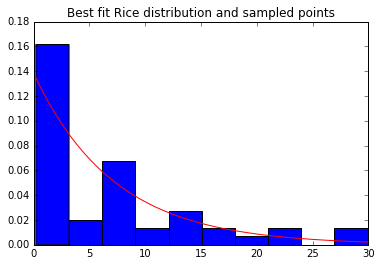

In [47]:
#Plot to see how it looks. Meh....

plt.hist(x_dat, normed=True)
x_vals = np.arange(0,30,.01)
plt.plot(x_vals, rice_likelihood(opt_r,x_vals), 'r-')
plt.title('Best fit Rice distribution and sampled points')

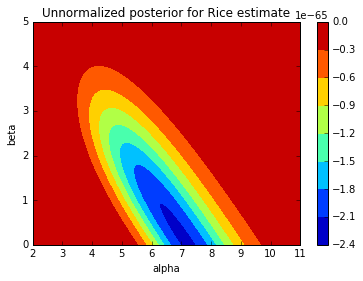

In [49]:
#Contour plot of posterior function, unnormalized

alp = np.linspace(2,11,100)
bet = np.linspace(0,5,100)
prob = np.array([[neg_RL((a,b),x_dat) for a in alp] for b in bet])
plt.contourf(alp, bet, prob)
plt.colorbar()
plt.xlabel('alpha')
plt.ylabel('beta')
plt.title('Unnormalized posterior for Rice estimate')

<h3>Problem 2</h3>

(128, 128, 128)


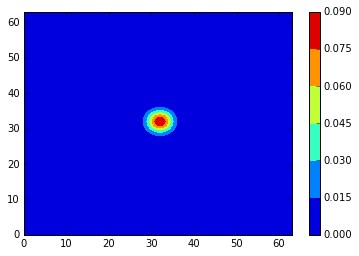

In [55]:
model_file = fits.open('../../hw6prob2_model.fits')
model_data = model_file[0].data
print(model_data.shape)

psf_file = fits.open('../../hw6prob2_psf.fits')
psf_data = psf_file[0].data
plt.contourf(psf_data)
plt.colorbar()

(128, 128)


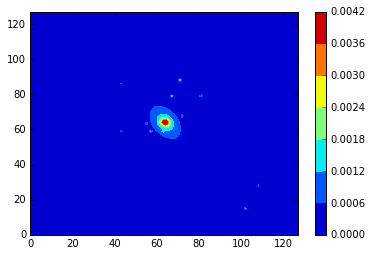

In [56]:
model_int = np.sum(model_data, axis=0)
print(model_int.shape)
plt.contourf(model_int)
plt.colorbar()

In [57]:
def zero_pad_2d(a, num):
    '''take an 2d array and pad with zeros around edges
    output is an array with size (num, num)'''
    
    a = np.asarray(a)
    size = a.shape
    
    out = np.zeros((num,num))
    
    out[int((num-size[0])/2):int((num+size[0])/2),int((num-size[1])/2):int((num+size[1])/2)] = a
    
    return out

In [36]:
#from timeit import timeit

def my_fft_1d(a, inverse=False, first_iter=True):
    '''Computes a fast fourier transform of a 1d array, a. 
    Returns a complex array of the same size. Uses the Cooley-Tukey algorithm'''
    
    n = len(a)
    out = np.zeros(n, dtype=complex)
    
    overall_factor = 1
    if inverse:
        s = -1
        if first_iter:
            overall_factor = float(1/n)
    else:
        s = 1
        
    if n == 1:
        out[0] = a[0]
    else:
        out[0:int(n/2)] = my_fft_1d(a[0::2], inverse, first_iter=False)
        out[int(n/2):] = my_fft_1d(a[1::2], inverse, first_iter=False)
        for k in range(0,int(n/2)):
            t = out[k]
            out[k] = t + np.exp(-s*2*np.pi*1j*k/n)*out[k+int(n/2)]
            out[k+int(n/2)] = t - np.exp(-s*2*np.pi*1j*k/n)*out[k+int(n/2)]
    return overall_factor*out

In [37]:
def my_fft_2d(a, inverse=False):
    '''Computes 2d FFT using my_fft_1d'''
    
    a = np.asarray(a)
    n1, n2 = a.shape
    if n1 != n2:
        print('Input must be a square array! Shape is', (n1,n2))
        return None
    N = n1
    out = np.zeros((N,N), dtype=complex)
    
    #FFT columns
    for i in range(0,N):
        out[:,i] = my_fft_1d(a[:,i], inverse, first_iter=True)
            
    #FFT rows
    for j in range(0,N):
        out[j,:] = my_fft_1d(out[j,:], inverse, first_iter=True)
        
    return out

/home/bijan/anaconda3/lib/python3.5/site-packages/numpy/ma/core.py:2720: ComplexWarning: Casting complex values to real discards the imaginary part
  _data = np.array(data, dtype=dtype, copy=copy, subok=True, ndmin=ndmin)


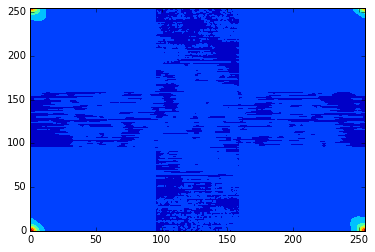

In [68]:
#Zero pad data
model_int_p = zero_pad_2d(model_int, 256)
psf_data_p = zero_pad_2d(psf_data, 256)
#plt.contourf(model_int)

#FFT padded data
model_int_f = my_fft_2d(model_int_p)
psf_data_f = my_fft_2d(psf_data_p)

#Do convolution in Fourier space, i.e. element-wise multiplication
conv_f = model_int_f*psf_data_f

#Inverse FFT back
conv = my_fft_2d(conv_f, inverse=True)
plt.contourf(conv)

/home/bijan/anaconda3/lib/python3.5/site-packages/numpy/ma/core.py:2720: ComplexWarning: Casting complex values to real discards the imaginary part
  _data = np.array(data, dtype=dtype, copy=copy, subok=True, ndmin=ndmin)


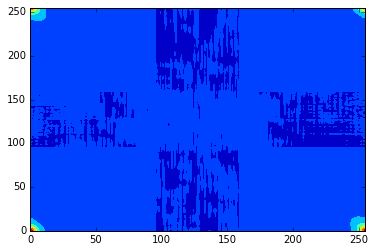

In [67]:
#Zero pad data
model_int = zero_pad_2d(model_int, 256)
psf_data = zero_pad_2d(psf_data, 256)
#plt.contourf(model_int)
#FFT padded data
model_int_f = np.fft.fft2(model_int)
psf_data_f = np.fft.fft2(psf_data)

#Do convolution in Fourier space
conv_f = model_int_f*psf_data_f
#plt.contourf(conv_f)

#Inverse FFT back
conv = np.fft.ifft2(conv_f)
plt.contourf(conv)

In [60]:
#Plot convolution
conv.shape
#plt.contourf(conv)
#plt.colorbar()

(256, 256)

In [41]:
t1 = np.linspace(0,2*np.pi,128)
t2 = np.linspace(0,2*np.pi,128)
t1, t2 = np.meshgrid(t1, t2)
a = np.sin(3*t1)*np.sin(7*t2)
a.shape

test = my_fft_2d(a)
test_1 = np.fft.fft2(a)

itest = my_fft_2d(test, inverse=True)
itest_1 = np.fft.ifft2(test_1)

print(itest-itest_1)

[[ -7.24515190e-17 -5.74870673e-19j  -1.23227208e-16 +2.78907008e-17j
   -1.55908129e-16 -3.83098616e-17j ...,  -6.86053856e-17 -8.23126295e-17j
   -1.39436958e-16 +4.82357692e-17j   1.33389076e-17 +8.14616422e-17j]
 [  2.79754495e-17 +2.12788655e-17j   2.01227923e-16 -6.21735492e-17j
   -1.24900090e-16 -1.62490187e-17j ...,   2.77555756e-17 -8.35355836e-17j
   -3.19189120e-16 -1.81050841e-17j  -3.52427111e-17 +3.28187503e-17j]
 [ -1.02193094e-16 -8.41610941e-17j   1.52655666e-16 +6.26425237e-17j
   -3.88578059e-16 -1.20579434e-16j ...,  -2.49800181e-16 -1.33510149e-16j
   -6.38378239e-16 -5.07234967e-17j  -3.36019069e-16 +1.27481957e-16j]
 ..., 
 [ -2.86526810e-17 -1.34451114e-17j  -1.66533454e-16 -1.49324417e-17j
    4.44089210e-16 -3.45509015e-16j ...,  -8.32667268e-17 +5.10069070e-17j
    4.02455846e-16 +2.43593664e-16j   2.91407510e-16 +1.74842205e-16j]
 [ -1.00509225e-16 -3.93687924e-17j  -2.84494650e-16 +3.97717848e-17j
    0.00000000e+00 +4.24676636e-17j ...,  -6.93889390e-17 -

In [52]:
a=np.zeros((2,2),dtype=complex)

In [35]:
t = np.linspace(0,2*np.pi,128)
a1 = np.sin(3*t)
test1 = my_fft_1d(a1)
test11 = np.fft.fft(a1)

itest1 = my_fft_1d(test1, inverse=True)
itest11 = np.fft.ifft(test11)
print(itest1-itest11)

[ -2.08166817e-17 +5.81132364e-17j   3.88578059e-16 +2.98907600e-18j
  -3.88578059e-16 +1.16374426e-16j   0.00000000e+00 -9.10262924e-17j
   3.33066907e-16 -1.73941613e-16j   7.77156117e-16 -9.18573221e-16j
   0.00000000e+00 -1.00978755e-16j   1.11022302e-16 -7.67568448e-16j
  -2.22044605e-16 +4.82898554e-16j   1.11022302e-16 +5.24286951e-17j
  -1.11022302e-16 +6.52837661e-16j   3.33066907e-16 -8.40873985e-17j
   1.11022302e-16 -6.52333859e-17j  -3.33066907e-16 -2.61511594e-16j
   2.22044605e-16 -6.08632749e-17j  -2.22044605e-16 -6.60449273e-16j
   4.44089210e-16 -4.15713945e-16j  -2.22044605e-16 -5.24744377e-16j
   7.77156117e-16 +1.29063226e-16j   4.44089210e-16 -1.76724646e-16j
   0.00000000e+00 -1.96074696e-16j  -8.53483950e-16 +1.88292447e-16j
   5.41233725e-16 +9.70145662e-17j   5.55111512e-17 +5.76544888e-16j
   7.77156117e-16 +4.61921060e-17j   3.33066907e-16 +2.36743064e-16j
   9.99200722e-16 -4.09328102e-16j   3.33066907e-16 +2.10381912e-16j
   2.22044605e-16 +3.45896078e-16j

In [66]:
np.multiply(np.array([[1,2],[3,4]]),np.array([[1,2],[3,4]]))

array([[ 1,  4],
       [ 9, 16]])